<a href="https://colab.research.google.com/github/MohitJuneja/FinBERT-1/blob/master/fastai_with_transformers_bert_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fastai with HuggingFace 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)

![fastai + Transformers](https://i.ibb.co/qspmrcm/fastai-transformers-1.png)

N.B. This implementation is a supplement of the Medium article ["Fastai with 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)"](https://medium.com/p/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2?source=email-29c8f5cf1dc4--writer.postDistributed&sk=119c3e5d748b2827af3ea863faae6376).

**Also, remember the upvote button is next to the fork button, and it's free too!** 😉

# Introduction : Story of transfer learning in NLP
In early 2018, Jeremy Howard (co-founder of fast.ai) and Sebastian Ruder introduced the  [Universal Language Model Fine-tuning for Text Classification](https://medium.com/r/?url=https%3A%2F%2Farxiv.org%2Fpdf%2F1801.06146.pdf) (ULMFiT) method. ULMFiT was the first **Transfer Learning** method applied to NLP. As a result, besides significantly outperforming many state-of-the-art tasks, it allowed, with only 100 labeled examples, to match performances equivalent to models trained on 100×  more data.

The first time I heard about ULMFiT was during a [fast.ai course](https://course.fast.ai/videos/?lesson=4) given by Jeremy Howard. He demonstrated how it was easy  -  thanks to the ``fastai`` library  -  to implement the complete ULMFit method with only a few lines of codes. In his demo, he used an AWD-LSTM neural network pre-trained on Wikitext-103 and get rapidly state-of-the-art results. He also explained key techniques - also demonstrated in ULMFiT - to fine-tune the models like **Discriminate Learning Rate**, **Gradual Unfreezing** or **Slanted Triangular Learning Rates**.

Since the introduction of ULMFiT, **Transfer Learning** became very popular in NLP and yet Google (BERT, Transformer-XL, XLNet), Facebook (RoBERTa, XLM) or even OpenAI (GPT, GPT-2) begin to pre-train their own model on very large corpora. This time, instead of using the AWD-LSTM neural network, they all used a more powerful architecture based on the Transformer (cf. [Attention is all you need](https://arxiv.org/abs/1706.03762)).

Although these models are powerful, ``fastai`` do not integrate all of them. Fortunately, [HuggingFace](https://huggingface.co/) 🤗 created the well know [transformers library](https://github.com/huggingface/transformers). Formerly knew as ``pytorch-transformers`` or ``pytorch-pretrained-bert``, this library brings together over 40 state-of-the-art pre-trained NLP models (BERT, GPT-2, RoBERTa, CTRL…). The implementation gives interesting additional utilities like tokenizer, optimizer or scheduler.

The ``transformers`` library can be self-sufficient but incorporating it within the ``fastai`` library provides simpler implementation compatible with powerful fastai tools like  **Discriminate Learning Rate**, **Gradual Unfreezing** or **Slanted Triangular Learning Rates**. The point here is to allow anyone — expert or non-expert — to get easily state-of-the-art results and to “make NLP uncool again”.

It worth noting that the integration of the HuggingFace ``transformers`` library in ``fastai`` has already been demonstrated in:
* Keita Kurita's article [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) which makes ``pytorch_pretrained_bert`` library compatible with ``fastai``.
* Dev Sharma's article [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) which makes ``pytorch_transformers`` library compatible with ``fastai``.

Although these articles are of high quality, some part of their demonstration is not anymore compatible with the last version of ``transformers``.


# 🛠 Integrating transformers with fastai for multiclass classification
Before beginning the implementation, note that integrating ``transformers`` within ``fastai`` can be done in multiple different ways. For that reason, I decided to bring simple solutions, that are the most generic and flexible. More precisely, I try to make the minimum of modification in both libraries while making them compatible with the maximum amount of transformer architectures.

Note that in addition to this NoteBook and the [Medium article](https://medium.com/p/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2?source=email-29c8f5cf1dc4--writer.postDistributed&sk=119c3e5d748b2827af3ea863faae6376), I made another version available on my GitHub(TODO add link).

## Libraries Installation
Before starting the implementation, you will need to install the ``fastai`` and ``transformers`` libraries. To do so, just follow the instructions [here](https://github.com/fastai/fastai/blob/master/README.md#installation) and [here](https://github.com/huggingface/transformers#installation).

In Kaggle, the ``fastai`` library is already installed. So you just have to instal ``transformers`` with :

In [2]:
#%%bash
!pip install transformers==2.5.1
!pip install fastai==1.0.58

     |████████████████████████████████| 501kB 13.6MB/s 
     |████████████████████████████████| 1.1MB 52.5MB/s 
     |████████████████████████████████| 133kB 38.4MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 3.7MB 53.9MB/s 
     |████████████████████████████████| 6.9MB 49.8MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=681ba35c0c5057e2060952d82d4d954e42fead394b6916d9eae1b9dfc6871835
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.23 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 245kB 15.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fasta

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

The current versions of the fastai and transformers libraries are respectively 1.0.58 and 2.5.1.

In [4]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.58
transformers version : 2.5.1


## 🎬 The example task
The chosen task is a multi-class text classification on [Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview).

For each text movie review, the model has to predict a label for the sentiment. We evaluate the outputs of the model on classification accuracy. The sentiment labels are:
* 0 → Negative
* 1 → Somewhat negative
* 2 → Neutral
* 3 → Somewhat positive
* 4 → Positive

The data is loaded into a ``DataFrame`` using ``pandas``.

In [5]:
!mkdir sentiment-analysis-on-movie-reviews
!mv *.zip sentiment-analysis-on-movie-reviews/

mv: cannot stat '*.zip': No such file or directory


In [6]:
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./.config/gce
./.config/config_sentinel
./.config/.last_opt_in_prompt.yaml
./.config/.last_survey_prompt.yaml
./.config/active_config
./.config/.last_update_check.json
./.config/.metricsUUID
./.config/logs/2020.11.13/17.33.44.836274.log
./.config/logs/2020.11.13/17.33.22.211003.log
./.config/logs/2020.11.13/17.33.45.553060.log
./.config/logs/2020.11.13/17.33.29.478721.log
./.config/logs/2020.11.13/17.32.45.071309.log
./.config/logs/2020.11.13/17.33.07.342211.log
./.config/configurations/config_default
./sentiment-analysis-on-movie-reviews/train.tsv.zip
./sentiment-analysis-on-movie-reviews/test.tsv.zip
./sample_data/README.md
./sample_data/anscombe.json
./sample_data/california_housing_train.csv
./sample_data/mnist_train_small.csv
./sample_data/mnist_test.csv
./sample_data/california_housing_test.csv


In [7]:
DATA_ROOT = Path(".") / "./sentiment-analysis-on-movie-reviews"
train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep="\t")
print(train.shape,test.shape)
train.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


It is worth noting that in the dataset there are no individual movie reviews but rather phrases taken out of context and split into smaller parts, each with an assigned sentiment label.

## Main transformers classes
In ``transformers``, each model architecture is associated with 3 main types of classes:
* A **model class** to load/store a particular pre-train model.
* A **tokenizer class** to pre-process the data and make it compatible with a particular model.
* A **configuration class** to load/store the configuration of a particular model.

For example, if you want to use the Bert architecture for text classification, you would use [``BertForSequenceClassification``](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification) for the **model class**, [``BertTokenizer``](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) for the **tokenizer class** and [``BertConfig``](https://huggingface.co/transformers/model_doc/bert.html#bertconfig) for the **configuration class**. 

In order to switch easily between classes  -  each related to a specific model type  -  I created a dictionary that allows loading the correct classes by just specifying the correct model type name.

In [8]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

You will see later, that those classes share a common class method ``from_pretrained(pretrained_model_name, ...)``. In our case, the parameter ``pretrained_model_name`` is a string with the shortcut name of a pre-trained model/tokenizer/configuration to load, e.g ``'bert-base-uncased'``. We can find all the shortcut names in the transformers documentation [here](https://huggingface.co/transformers/pretrained_models.html#pretrained-models).

In [9]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [10]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

Print the available values for ``pretrained_model_name`` (shortcut names) corresponding to the ``model_type`` used.

In [11]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

It is worth noting that in this case, we use the ``transformers`` library only for a multi-class text classification task. For that reason, this tutorial integrates only the transformer architectures that have a model for sequence classification implemented. These model types are :
* BERT (from Google)
* XLNet (from Google/CMU)
* XLM (from Facebook)
* RoBERTa (from Facebook)
* DistilBERT (from HuggingFace)

However, if you want to go further - by implementing another type of model or NLP task - this tutorial still an excellent starter.

## Util function

Function to set the seed for generating random numbers.

In [12]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [13]:
seed_all(seed)

## Data pre-processing

To match pre-training, we have to format the model input sequence in a specific format.
To do so, you have to first **tokenize** and then **numericalize** the texts correctly.
The difficulty here is that each pre-trained model, that we will fine-tune, requires exactly the same specific pre-process - **tokenization** & **numericalization** - than the pre-process used during the pre-train part.
Fortunately, the **tokenizer class** from ``transformers`` provides the correct pre-process tools that correspond to each pre-trained model.

In the ``fastai`` library, data pre-processing is done automatically during the creation of the ``DataBunch``. 
As you will see in the ``DataBunch`` implementation, the **tokenizer** and **numericalizer** are passed in the processor argument under the following format :

``processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]``

Let's first analyse how we can integrate the ``transformers`` **tokenizer** within the ``TokenizeProcessor`` function.

### Custom Tokenizer
This part can be a little bit confusing because a lot of classes are wrapped in each other and with similar names.
To resume, if we look attentively at the ``fastai`` implementation, we notice that :
1. The [``TokenizeProcessor`` object](https://docs.fast.ai/text.data.html#TokenizeProcessor) takes as ``tokenizer`` argument a ``Tokenizer`` object.
2. The [``Tokenizer`` object](https://docs.fast.ai/text.transform.html#Tokenizer) takes as ``tok_func`` argument a ``BaseTokenizer`` object.
3. The [``BaseTokenizer`` object](https://docs.fast.ai/text.transform.html#BaseTokenizer) implement the function ``tokenizer(t:str) → List[str]`` that take a text ``t`` and returns the list of its tokens.

Therefore, we can simply create a new class ``TransformersBaseTokenizer`` that inherits from ``BaseTokenizer`` and overwrite a new ``tokenizer`` function.


In [14]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [15]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :
1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with ``add_prefix_space`` set to ``True``.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.

    bert:       [CLS] + tokens + [SEP] + padding

    roberta:    [CLS] + prefix_space + tokens + [SEP] + padding
    
    distilbert: [CLS] + tokens + [SEP] + padding

    xlm:        [CLS] + tokens + [SEP] + padding

    xlnet:      padding + tokens + [SEP] + [CLS]
    
It is worth noting that we don't add padding in this part of the implementation. 
As we will see later, ``fastai`` manage it automatically during the creation of the ``DataBunch``.

### Custom Numericalizer

In ``fastai``, [``NumericalizeProcessor``  object](https://docs.fast.ai/text.data.html#NumericalizeProcessor) takes as ``vocab`` argument a [``Vocab`` object](https://docs.fast.ai/text.transform.html#Vocab). 
From this analyse, we suggest two ways to adapt the fastai numericalizer:
1. You can, like decribed in the [Dev Sharma's article](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Section *1. Setting Up the Tokenizer*), retreive the list of tokens and create a ``Vocab`` object.
2. Create a new class ``TransformersVocab`` that inherits from ``Vocab`` and overwrite ``numericalize`` and ``textify`` functions.

Even if the first solution seems to be simpler, ``Transformers`` does not provide, for all models, a straightforward way to retreive his list of tokens. 
Therefore, I implemented the second solution, which runs for each model type.
It consists of using the functions ``convert_tokens_to_ids`` and ``convert_ids_to_tokens`` in respectively ``numericalize`` and ``textify``.

In [17]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

NB: The functions ``__gestate__`` and ``__setstate__`` allow the functions [export](https://docs.fast.ai/basic_train.html#Learner.export) and [load_learner](https://docs.fast.ai/basic_train.html#load_learner) to work correctly with ``TransformersVocab``.

### Custom processor
Now that we have our custom **tokenizer** and **numericalizer**, we can create the custom **processor**. Notice we are passing the ``include_bos = False`` and ``include_eos = False`` options. This is because ``fastai`` adds its own special tokens by default which interferes with the ``[CLS]`` and ``[SEP]`` tokens added by our custom tokenizer.

In [18]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor ``transformer_processor`` and manage correctly the padding.

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [19]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [20]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

There is multible ways to create a DataBunch, in our implementation, we use [the data block API](https://docs.fast.ai/data_block.html#The-data-block-API), which gives more flexibility.

In [21]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Check batch and tokenizer :

In [22]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
"<s> Ġ- L RB - ĠCity Ġ- RR B - Ġreminds Ġus Ġhow Ġrealistically Ġnuanced Ġa ĠRobert ĠDe ĠN iro Ġperformance Ġcan Ġbe Ġwhen Ġhe Ġis Ġnot Ġmore Ġluc r atively Ġengaged Ġin Ġthe Ġshameless Ġself - car ic ature Ġof Ġ` ĠAnaly ze ĠThis Ġ' Ġ- L RB - Ġ1999 Ġ- RR B - Ġand Ġ` ĠAnaly ze ĠThat Ġ, Ġ' Ġpromised Ġ- L RB - Ġor Ġthreatened Ġ-",3
"<s> ĠThe Ġreal Ġtriumph s Ġin ĠIg by Ġcome Ġfrom ĠPhilippe Ġ, Ġwho Ġmakes ĠOliver Ġfar Ġmore Ġinteresting Ġthan Ġthe Ġcharacter Ġ' s Ġlines Ġwould Ġsuggest Ġ, Ġand ĠSar andon Ġ, Ġwho Ġcould Ġn 't Ġbe Ġbetter Ġas Ġa Ġcruel Ġbut Ġweird ly Ġlik able ĠWAS P Ġmat ron Ġ. </s>",3
"<s> ĠParker Ġshould Ġbe Ġcomm ended Ġfor Ġtaking Ġa Ġfresh Ġapproach Ġto Ġfamiliar Ġmaterial Ġ, Ġbut Ġhis Ġdetermination Ġto Ġremain Ġtrue Ġto Ġthe Ġoriginal Ġtext Ġleads Ġhim Ġto Ġadopt Ġa Ġsomewhat Ġman nered Ġtone Ġ... Ġthat Ġultimately Ġdull s Ġthe Ġhuman Ġtragedy Ġat Ġthe Ġstory Ġ' s Ġcore </s>",2
"<s> ĠIt Ġ' s Ġa Ġlong Ġway Ġfrom ĠOrwell Ġ' s Ġdark Ġ, Ġintelligent Ġwarning Ġcry Ġ- L RB - Ġ1984 Ġ- RR B - Ġto Ġthe Ġempty Ġstud Ġknock about Ġof ĠEqu ilibrium Ġ, Ġand Ġwhat Ġonce Ġwas Ġconviction Ġis Ġnow Ġaffect ation Ġ. </s>",1
"<s> ĠA Ġdifferent Ġand Ġemotionally Ġreserved Ġtype Ġof Ġsurvival Ġstory Ġ-- Ġa Ġfilm Ġless Ġabout Ġref ract ing Ġall Ġof ĠWorld ĠWar ĠII Ġthrough Ġthe Ġspecific Ġconditions Ġof Ġone Ġman Ġ, Ġand Ġmore Ġabout Ġthat Ġman Ġlost Ġin Ġits Ġmidst Ġ. </s>",3


Check batch and numericalizer :

In [23]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 79])
tensor([[    0,   111,   574,  ...,    76,   479,     2],
        [    0,    33,     7,  ...,     1,     1,     1],
        [    0,   318,    47,  ...,     1,     1,     1],
        ...,
        [    0,     5,  2156,  ...,     1,     1,     1],
        [    0,    33, 30291,  ...,     1,     1,     1],
        [    0, 45518, 10730,  ...,     1,     1,     1]])


### Custom model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits. 
One way to access them is to create a custom model.

In [24]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels. To do so, you can modify the config instance or either modify like in [Keita Kurita's article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (Section: *Initializing the Learner*) the ``num_labels`` argument.

In [25]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_id": 2,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_

In [27]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [28]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [29]:
# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Not working in the tutorial
if use_fp16: learner = learner.to_fp16()

In [30]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Learner : Custom Optimizer / Custom Metric
In ``pytorch-transformers``, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer.
This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within ``fastai``.
It is worth noting that for reproducing BertAdam specific behavior, you have to set ``correct_bias = False``.


In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

## Discriminative Fine-tuning and Gradual unfreezing (Optional)
To use **discriminative layer training** and **gradual unfreezing**, ``fastai`` provides one tool that allows to "split" the structure model into groups. An instruction to perform that "split" is described in the fastai documentation [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training).

Unfortunately,  the model architectures are too different to create a unique generic function that can "split" all the model types in a convenient way. Thereby, you will have to implement a custom "split" for each different model architecture.

For example, if we use the RobBERTa model and that we observe his architecture by making ``print(learner.model)``.

In [31]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

In this case, we can split our model in this way :

In [32]:
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')

Learner split in 1 groups


In [33]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

learner.split(list_layers);

Check groups : 

In [34]:
learner.split(list_layers)
# learner.split(list_layers)
# num_groups = len(learner.layer_groups)
# print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)


Learner(data=TextClasDataBunch;

Train: LabelList (140454 items)
x: TextList
<s> ĠA Ġseries Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>,<s> ĠA Ġseries </s>,<s> ĠA </s>,<s> Ġseries </s>,<s> Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>
y: CategoryList
2,2,2,2,2
Path: .;

Valid: LabelList (15606 items)
x: TextList
<s> Ġ' s Ġas Ġsorry </s>,<s> ĠRomantic Ġcomedy Ġand ĠDog me Ġ95 Ġfilmmaking Ġmay Ġseem Ġodd Ġbed fell ows Ġ, Ġbut Ġthey Ġturn Ġout Ġto Ġbe Ġdelight fully Ġcompatible Ġhere </s>,<s> Ġof Ġthese Ġdays </s>,<s> Ġfl inch Ġfrom Ġits Ġunsettling Ġprog nosis </s>,<s> Ġare Ġclinically Ġdepressed </s>
y: CategoryList
2,4,2,2,1
Path: .;

Test: LabelList (66292 items)
x: TextList
<s> Ġ15 60 61 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort Ġ. </s>,<s> Ġ15 60 62 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort </s>,<s> Ġ15 60 63 Ġ85 45 ĠAn </s>,<s> Ġ15 60 64 Ġ85 45

Note that I didn't found any document that has studied the influence of **Discriminative Fine-tuning** and **Gradual unfreezing** or even **Slanted Triangular Learning Rates** with transformers. Therefore, using these tools does not guarantee better results. If you found any interesting documents, please let us know in the comment.

## Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [35]:
learner.save('untrain')

In [36]:
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the classifier with :

In [37]:
learner.freeze_to(-1)

We check which layer are trainable.

In [38]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [79, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [79, 768]            394,752    False     
______________________________________________________________________
Embedding            [79, 768]            768        False     
______________________________________________________________________
LayerNorm            [79, 768]            1,536      False     
______________________________________________________________________
Dropout              [79, 768]            0          False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
_______________________________________

For **Slanted Triangular Learning Rates** you have to use the function ``one_cycle``. For more information please check the fastai documentation [here](https://docs.fast.ai/callbacks.one_cycle.html). 

To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [39]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 4.37E-04


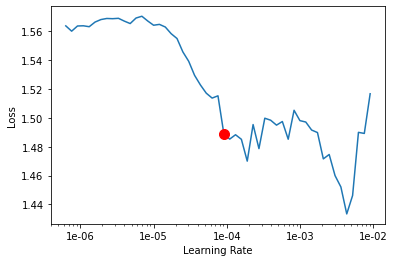

In [40]:
learner.recorder.plot(skip_end=10,suggestion=True)

We will pick a value a bit before the minimum, where the loss still improves. Here 2x10^-3 seems to be a good value.

Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.002275,0.986149,0.599000,0.401000,03:39


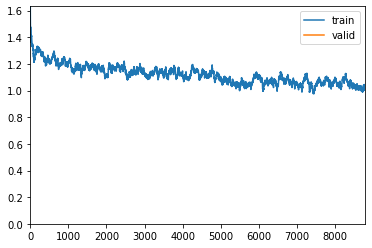

In [41]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [42]:
learner.save('first_cycle')

In [43]:
seed_all(seed)
learner.load('first_cycle');

We then unfreeze the second group of layers and repeat the operations.

In [44]:
learner.freeze_to(-2)

In [45]:
lr = 1e-5

Note here that we use slice to create separate learning rate for each group.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.919810,0.899031,0.636230,0.363770,04:35


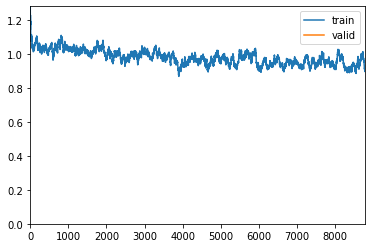

In [46]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [47]:
learner.save('second_cycle')

In [48]:
seed_all(seed)
learner.load('second_cycle');

In [49]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.881620,0.867503,0.648340,0.351660,05:12


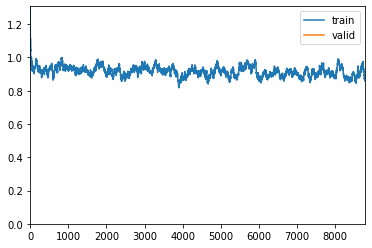

In [50]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [51]:
learner.save('third_cycle')

In [52]:
seed_all(seed)
learner.load('third_cycle');

Here, we unfreeze all the groups.

In [53]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.709351,0.718610,0.700500,0.299500,14:58
1,0.651286,0.697563,0.709407,0.290593,14:26


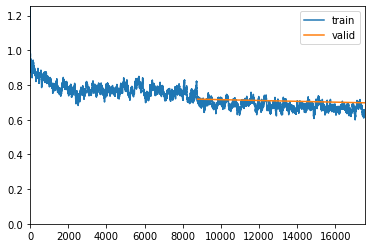

In [54]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

Now, you can predict examples with:

In [55]:
learner.predict('This is the best movie of 2020')

(Category 4,
 tensor(4),
 tensor([7.5244e-06, 6.5012e-06, 7.5402e-05, 1.8518e-02, 9.8139e-01]))

In [56]:
learner.predict('This is the worst movie of 2020')

(Category 0,
 tensor(0),
 tensor([9.6383e-01, 3.3977e-02, 1.2203e-03, 1.8969e-04, 7.8354e-04]))

## Export Learner
In order to export and load the learner you can do these operations:

In [57]:
learner.export(file = 'transformer.pkl');

In [58]:
path = './'
export_learner = load_learner(path, file = 'transformer.pkl')

As mentioned [here](https://docs.fast.ai/basic_train.html#load_learner), you have to be careful that each custom classes - like ``TransformersVocab`` - are first defined before executing ``load_learner``.

In [59]:
export_learner.predict('This is the worst movie of 2020')

(Category 0,
 tensor(0),
 tensor([9.6383e-01, 3.3977e-02, 1.2203e-03, 1.8969e-04, 7.8354e-04]))

## Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

As specified in Keita Kurita's [article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/), as the function ``get_preds`` does not return elements in order by default, you will have to resort the elements into their correct order.

In [60]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

<enum 'DatasetType'>

In [61]:
sample_submission = pd.read_csv('sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)

FileNotFoundError: ignored

We check the order.

In [ ]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [ ]:
sample_submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [ ]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='predictions.csv')

In [69]:
TextList.from_df()

TypeError: ignored

We can now submit our predictions to Kaggle !  In our example, without playing too much with the parameters, we get a score of 0.70059, which leads us to the 5th position on the leaderboard! 

# Conclusion

In this NoteBook, I explain how to combine the ``transformers`` library with the beloved ``fastai`` library. It aims to make you understand where to look and modify both libraries to make them work together. Likely, it allows you to use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and even **Gradual Unfreezing**. As a result, without even tunning the parameters, you can obtain rapidly state-of-the-art results.

This year, the transformers became an essential tool to NLP. Because of that, I think that pre-trained transformers architectures will be integrated soon to future versions of fastai. Meanwhile, this tutorial is a good starter.

I hope you enjoyed this first article and found it useful. 
Thanks for reading and don't hesitate in leaving questions or suggestions.


# References
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)